In [1]:
import re
import math
import xml.etree.ElementTree as ET
from collections import defaultdict, Counter
import tkinter as tk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

query_expansion_map = {
    "dbms": "database management system",
    "ai": "artificial intelligence",
    "ml": "machine learning",
    "nlp": "natural language processing",
    "introductory": "introduction fundamentals basics overview",
    "lab": "laboratory",
    "easy": "foundation beginner fundamentals" 
}


In [2]:
def classify_course(course_code):
    code_num = int(re.findall(r'\d+', course_code)[0])

    if 5000 <= code_num <= 5009:
        return "Master's Align"
    elif code_num < 5000:
        return "Undergraduate"
    return "Unclassified"

def is_easy_course(description):
    easy_keywords = ["foundation", "beginner", "fundamentals", "introductory", "basic"]
    description = description.lower()
    return any(keyword in description for keyword in easy_keywords)


In [3]:
query_relevance_map = {
    "which courses teach about artificial intelligence?": ["CS 4050", "CS 4100", "CS 4150", "CS 5100", "CS 5150", "CS 5170", "CS 7170", "CS 7180"],
    "what are the prerequisites of cs6140?":["CS 5800"],
    "what couses introduce Machine Learning?": ["CS 6140", "CS 7140", "CS 7332", "CS 4050", "CS 4100", "CS 4150", "CS 5100", "CS 5150", "CS 5170", "CS 7170", "CS 7180"],
    "which courses cover data structures?": ["CS 5002", "CS 1800", "CS 5008", "CS3000"],
    "what are some easy courses in ai?": ["CS5100","CS4100","CS 4050", "CS 4150", "CS 5150", "CS 5170", "CS5047"],
    "which courses are labs or include lab work?": ["CS 1101", "CS 2501", "CS 2511", "CS 3501"],
    "find a course that teaches databases or dbms.": ["CS 3200", "CS 5200", "7280", "7240", "7270"],
    "courses that include natural language processing.": ["CS4120", "CS 6120", "CS4100", "CS7150"],
    "introductory and (ai or machine learning)": ["CS 1100", "CS 5100", "CS 4050"],
    "game programming  and not (web or mobile)": ["CS 3540", "CS 5540"],
    "courses that list cs 1101 as a corequisite.": ["CS 1100"],
    "which 4-credit-hour courses are ai-related?": ["CS 4050", "CS 4100", "CS 4150", "CS 5100", "CS 5150", "CS 5170", "CS 7180"],
    "master's align courses only.": ["CS 5001", "CS 5002", "CS 5004", "CS 5008"],
    "undergrad courses with prerequisites.": ["CS 1210", "CS 2800","CS 3000", "CS 3650", "CS 3800", "CS 3950","CS 4097", "CS 4180", "CS 4300", "CS 4730", "CS 4810", "CS 4500", "CS 4700", "CS 4820", "CS 4850", "CS 4992", "CS 4950", "CS 4955"],
    "introductory database courses.": ["CS 3200", "CS 5200"],
    "courses for software developers": ["CS 4500", "CS 6510", "CS 7575", "CS 4530", "CS5500", "CS7580", "CS4520", "CS5520", "CS5610"]
}



In [4]:
def preprocess_text(text):
    tokens = re.findall(r"\b\w+\b", text.lower())
    return [stemmer.stem(t) for t in tokens if t not in stop_words]


In [5]:
import networkx as nx
import xml.etree.ElementTree as ET

def build_prerequisite_graph(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    G = nx.DiGraph()

    for course in root.findall("course"):
        code = course.findtext("code", default="").strip()
        if not code or code.lower() == "none":
            continue
        G.add_node(code)

        prereq_tag = course.find("prerequisites")
        if prereq_tag is not None:
            for prereq in prereq_tag.findall("prerequisite"):
                prereq_code = prereq.text.strip()
                if prereq_code and prereq_code.lower() != "none":
                    G.add_edge(prereq_code, code)
    return G


In [6]:
def build_index(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    inv_index = defaultdict(set)
    documents = {}
    meta = {}

    for course in root.findall("course"):
        code = course.find("code").text.strip()
        name = course.find("name").text.strip()
        desc = course.find("description").text.strip()
        hours = course.find("hours").text.strip()

        pre = course.find("prerequisites")
        co = course.find("corequisites")

        prereqs = [p.text.strip() for p in pre.findall("prerequisite")] if pre is not None else []
        coreqs = [c.text.strip() for c in co.findall("corequisite")] if co is not None else []

        tokens = preprocess_text(f"{name} {desc}")  # Includes unigrams and bigrams
        documents[code] = tokens
        meta[code] = {
            "name": name,
            "description": desc,
            "hours": int(hours) if hours.isdigit() else 0,
            "prerequisites": prereqs,
            "corequisites": coreqs
        }

        for token in tokens:
            inv_index[token].add(code)  # Index both unigrams and bigrams

    return inv_index, documents, meta

In [7]:
from collections import defaultdict

def build_prereq_graph(meta):
    graph = defaultdict(set)
    for course, data in meta.items():
        for prereq in data["prerequisites"]:
            if prereq in meta:
                graph[prereq].add(course)
    return graph


In [8]:
import networkx as nx

def compute_pagerank(graph, alpha=0.85, max_iter=100, tol=1e-6):
    return nx.pagerank(graph, alpha=alpha, max_iter=max_iter, tol=tol)


In [9]:
def rerank_with_pagerank(results, pagerank, weight=0.2):
    return sorted(results, key=lambda x: pagerank.get(x[0], 0) * weight, reverse=True)


In [10]:
def get_prerequisites(course_code, graph):
    return list(graph.predecessors(course_code))

def get_all_prerequisites(course_code, graph):
    return list(nx.ancestors(graph, course_code))

def get_dependent_courses(course_code, graph):
    return list(graph.successors(course_code))

def get_all_dependents(course_code, graph):
    return list(nx.descendants(graph, course_code))

def get_recursive_prerequisites(course_code, graph):
    return list(nx.ancestors(graph, course_code))

def get_recursive_dependents(course_code, graph):
    return list(nx.descendants(graph, course_code))



In [11]:
from nltk import ngrams  # Add to imports at the top

def preprocess_text(text):
    tokens = re.findall(r"\b\w+\b", text.lower())
    tokens = [stemmer.stem(t) for t in tokens if t not in stop_words]
    # Generate bigrams from stemmed tokens
    bigrams = ['_'.join(bigram) for bigram in ngrams(tokens, 2)]  # e.g., "program_design"
    return tokens + bigrams

def preprocess_query(query, expand=False):
    tokens = re.findall(r"\b\w+\b", query.lower())
    if expand:
        expanded = []
        for t in tokens:
            if t in query_expansion_map:
                expanded += query_expansion_map[t].split()
            else:
                expanded.append(t)
        tokens = expanded
    tokens = [stemmer.stem(t) for t in tokens if t not in stop_words]
    # Generate bigrams from stemmed tokens
    bigrams = ['_'.join(bigram) for bigram in ngrams(tokens, 2)]
    return tokens + bigrams

def process_boolean_query(tokens, inv_index):
    result = set()
    op = "OR"
    for token in tokens:
        if token.upper() in {"AND", "OR", "NOT"}:
            op = token.upper()
        else:
            docs = inv_index.get(token, set())
            if op == "OR":
                result |= docs
            elif op == "AND":
                result &= docs if result else docs
            elif op == "NOT":
                result -= docs
    return result


In [12]:
k1, b = 1.5, 0.75

def compute_bm25_scores(query_tokens, documents, meta):
    N = len(documents)
    avg_dl = sum(len(doc) for doc in documents.values()) / N
    df = defaultdict(int)

    for doc in documents.values():
        for term in set(doc):
            df[term] += 1

    idf = {term: math.log((N - df[term] + 0.5) / (df[term] + 0.5) + 1) for term in query_tokens}
    scores = {}

    for doc_id, doc in documents.items():
        tf = Counter(doc)
        dl = len(doc)
        score = 0
        for term in query_tokens:
            if term in tf:
                f = tf[term]
                weight = 1.5 if '_' in term else 1.0  
                score += weight * idf[term] * ((f * (k1 + 1)) / (f + k1 * (1 - b + b * dl / avg_dl)))
        if score > 0:
            hours = meta.get(doc_id, {}).get("hours", 0)
            adjusted_score = score - 0.05 * hours  
            scores[doc_id] = adjusted_score

    return dict(sorted(scores.items(), key=lambda x: x[1], reverse=True))

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def compute_tfidf_scores(query_tokens, documents):
    doc_ids = list(documents.keys())
    corpus = [' '.join(documents[doc_id]) for doc_id in doc_ids]
    query = ' '.join(query_tokens)  # Includes bigrams
    vectorizer = TfidfVectorizer(ngram_range=(1, 2))  # Add bigrams
    tfidf_matrix = vectorizer.fit_transform(corpus + [query])
    query_vec = tfidf_matrix[-1]
    doc_vecs = tfidf_matrix[:-1]
    similarities = cosine_similarity(query_vec, doc_vecs).flatten()
    scores = {doc_ids[i]: float(similarities[i]) for i in range(len(doc_ids)) if similarities[i] > 0}
    return dict(sorted(scores.items(), key=lambda x: x[1], reverse=True))


In [14]:
def search(query, inv_index, documents, meta, use_bm25=True, use_tfidf=False, expand=True, pagerank=None, boost_weight=0.2):
    tokens = preprocess_query(query, expand=expand)
    query_lower = query.lower().strip()

    # Determine course level filters
    is_align = "master's align" in query_lower or "masters align" in query_lower or "master align" in query_lower or "align" in query_lower
    is_master = ("master's" in query_lower or "masters" in query_lower or "master" in query_lower) and not is_align
    is_undergrad = "undergrad" in query_lower or "undergraduate" in query_lower

    # Extract course codes
    course_codes = re.findall(r'\bCS\s*\d{4}\b', query.upper())
    course_codes = [f"CS {re.search(r'\d{4}', code).group(0)}" for code in course_codes]

    # Handle corequisite queries
    if "corequisite" in query_lower:
        if course_codes:
            results = []
            for code, data in meta.items():
                if any(c in data["corequisites"] for c in course_codes):
                    results.append((code, data))
            return results
        else:
            results = [(code, data) for code, data in meta.items() if data["corequisites"]]
            return results

    # Handle prerequisite/dependent queries
    if course_codes:
        if "prerequisite" in query_lower or "prerequisites" in query_lower:
            if "all" in query_lower or "complete list" in query_lower or "entire chain" in query_lower:
                prereqs = get_recursive_prerequisites(course_codes[0], prereq_graph)
                return [(code, meta[code]) for code in prereqs if code in meta]
            else:
                prereqs = list(prereq_graph.predecessors(course_codes[0]))
                return [(code, meta[code]) for code in prereqs if code in meta]
        elif "for" in query_lower or "before" in query_lower or "needed" in query_lower:
            prereqs = list(prereq_graph.predecessors(course_codes[0]))
            return [(code, meta[code]) for code in prereqs if code in meta]
        elif "have" in query_lower or "require" in query_lower or "after" in query_lower:
            if len(course_codes) > 1 and "and" in query_lower:
                dependents = set()
                for course_code in course_codes:
                    try:
                        course_dependents = set(prereq_graph.successors(course_code))
                        if not dependents:
                            dependents = course_dependents
                        else:
                            dependents &= course_dependents
                    except nx.NetworkXError:
                        return []
                return [(code, meta[code]) for code in dependents if code in meta]
            else:
                try:
                    dependents = list(prereq_graph.successors(course_codes[0]))
                    return [(code, meta[code]) for code in dependents if code in meta]
                except nx.NetworkXError:
                    return []
        elif "what comes after" in query_lower or "all dependents" in query_lower:
            dependents = get_recursive_dependents(course_codes[0], prereq_graph)
            return [(code, meta[code]) for code in dependents if code in meta]

    # Handle "courses with prerequisites" explicitly
    if "prerequisites" in query_lower and not course_codes:
        candidates = set()
        for code, data in meta.items():
            if data["prerequisites"]:  # Check non-empty prerequisites
                candidates.add(code)
    else:
        # Standard keyword search
        if any(op in query.upper() for op in ("AND", "OR", "NOT")):
            candidates = process_boolean_query(tokens, inv_index)
        else:
            candidates = set()
            for token in tokens:
                candidates |= inv_index.get(token, set())

    if use_tfidf:
        scores = compute_tfidf_scores(tokens, documents)
    elif use_bm25:
        scores = compute_bm25_scores(tokens, documents, meta)
    else:
        scores = {}

    def filter_course(code):
        try:
            num = int(code.split()[1]) if code.startswith("CS ") else 0
            if is_master:
                return num >= 5000
            elif is_align:
                return 5000 <= num <= 5009
            elif is_undergrad:
                return num < 5000
            return True
        except (ValueError, IndexError):
            return False

    filtered_candidates = {code for code in candidates if filter_course(code)}
    results = [(code, meta[code]) for code in scores if code in filtered_candidates] if scores else [(code, meta[code]) for code in filtered_candidates]

    if pagerank:
        for i, (code, data) in enumerate(results):
            data["score"] = scores.get(code, 0) + boost_weight * pagerank.get(code, 0)
        results = sorted(results, key=lambda x: x[1]["score"], reverse=True)
    elif scores:
        results = sorted(results, key=lambda x: scores.get(x[0], 0), reverse=True)

    return results

In [15]:
def precision_at_k(results, relevant, k=10):
    retrieved = [r[0] for r in results[:k]]
    return len(set(retrieved) & set(relevant)) / k

def ndcg_at_k(results, relevant, k=10):
    def dcg(rel):
        return sum([1 / math.log2(i + 2) if rel[i] else 0 for i in range(len(rel))])
    rels = [1 if r[0] in relevant else 0 for r in results[:k]]
    ideal = sorted(rels, reverse=True)
    return dcg(rels) / (dcg(ideal) or 1)


In [16]:
import tkinter as tk

def run_tk_gui(inv_index, docs, meta, pagerank_scores):
    def on_search():
        query = entry.get()
        result_display.config(state='normal')
        result_display.delete("1.0", tk.END)
        eval_label.config(text="")

        results = search(
            query,
            inv_index,
            docs,
            meta,
            use_bm25=not tfidf_var.get(),
            use_tfidf=tfidf_var.get(),
            pagerank=pagerank_scores if pagerank_var.get() else None
        )

        for i, (code, data) in enumerate(results[:10], 1):
            result_display.insert(tk.END, f"{i}. {code} — {data['name']}\n")
            result_display.insert(tk.END, f"   Description     : {data['description']}\n")
            result_display.insert(tk.END, f"   Prerequisite(s) : {', '.join(data['prerequisites']) or 'None'}\n")
            result_display.insert(tk.END, f"   Corequisite(s)  : {', '.join(data['corequisites']) or 'None'}\n")
            result_display.insert(tk.END, f"   Hours           : {data['hours']}\n")
            result_display.insert(tk.END, "-" * 100 + "\n")

        result_display.config(state='disabled')

        q_clean = query.lower().strip()
        if q_clean in query_relevance_map:
            relevant = query_relevance_map[q_clean]
            p10 = precision_at_k(results, relevant)
            ndcg = ndcg_at_k(results, relevant)
            eval_label.config(
                text=f"📊 Evaluation for '{q_clean}':  Precision@10 = {p10:.2f},  nDCG@10 = {ndcg:.2f}"
            )
        else:
            eval_label.config(text="📊 No relevance data for this query.")

    root = tk.Tk()
    root.title("Course Search Engine")

    tk.Label(root, text="Search Query:").pack()
    entry = tk.Entry(root, width=100)
    entry.pack(pady=4)

    tfidf_var = tk.BooleanVar()
    pagerank_var = tk.BooleanVar()
    tk.Checkbutton(root, text="Use TF-IDF instead of BM25", variable=tfidf_var).pack()
    tk.Checkbutton(root, text="Boost with PageRank", variable=pagerank_var).pack()

    tk.Button(root, text="Search", command=on_search).pack(pady=4)

    result_display = tk.Text(root, width=200, height=50, wrap="word")
    result_display.pack(padx=5, pady=5)
    result_display.config(state='disabled')

    eval_label = tk.Label(root, text="", font=("Helvetica", 16), fg="green")
    eval_label.pack(pady=5)

    root.mainloop()


In [17]:
def cli_search_interface(inv_index, docs, meta):
    print("=== Course Search Engine (CLI) ===")
    print("Type 'exit' to quit.\n")
    while True:
        query = input("Search Query: ")
        if query.lower() == "exit":
            break

        results = search(query, inv_index, docs, meta)

        print("\nTop Results:")
        for i, (code, data) in enumerate(results[:10], 1):
            print(f"{i}.")
            print(f"Course code     : {code}")
            print(f"Course name     : {data['name']}")
            print(f"Description     : {data['description']}")
            print(f"Prerequisite(s) : {', '.join(data['prerequisites']) or 'None'}")
            print(f"Corequisite(s)  : {', '.join(data['corequisites']) or 'None'}")
            print(f"Hours           : {data['hours']}")
            print("-" * 40)

        q_clean = query.lower().strip()
        if q_clean in query_relevance_map:
            relevant = query_relevance_map[q_clean]
            p10 = precision_at_k(results, relevant)
            ndcg = ndcg_at_k(results, relevant)
            print(f"📊 Evaluation for '{q_clean}':  Precision@10 = {p10:.2f},  nDCG@10 = {ndcg:.2f}")
        else:
            print("📊 No relevance data for this query.\n")


In [18]:
if __name__ == "__main__":
    xml_file = "cs_courses.xml"
    inv_index, docs, meta = build_index(xml_file)
    prereq_graph = build_prerequisite_graph("cs_courses.xml")
    pagerank_scores = compute_pagerank(prereq_graph)

    # mode = input("Choose interface [cli/gui]: ").lower()
    # if mode == "cli":
    #     cli_search_interface(inv_index, docs, meta)
    # elif mode == "gui":
    #     run_tk_gui(inv_index, docs, meta, pagerank_scores)

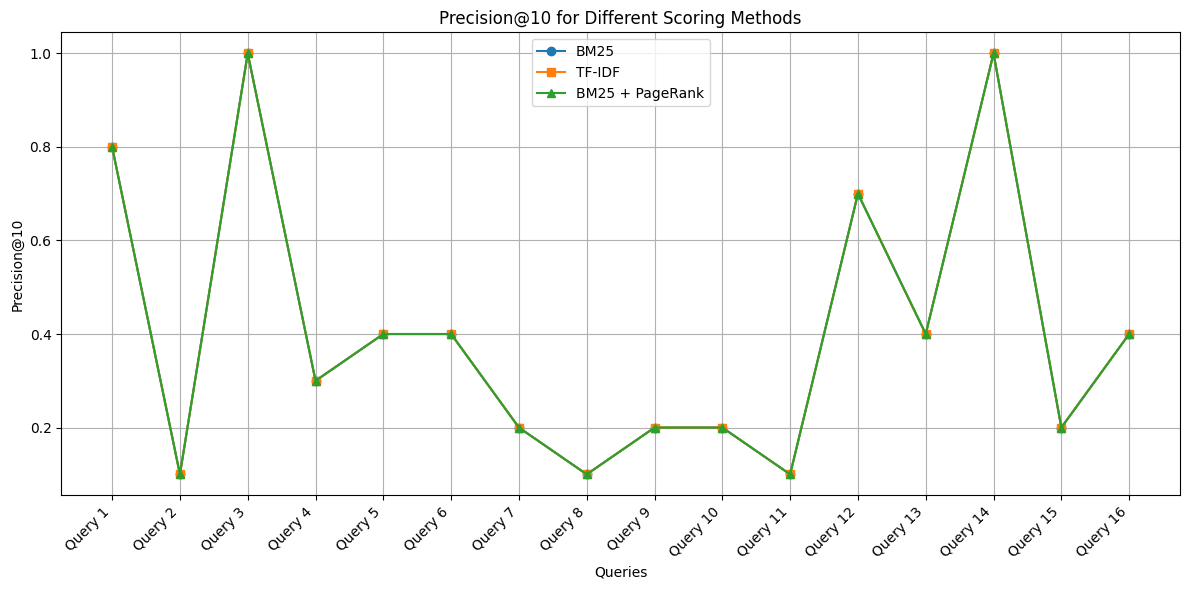

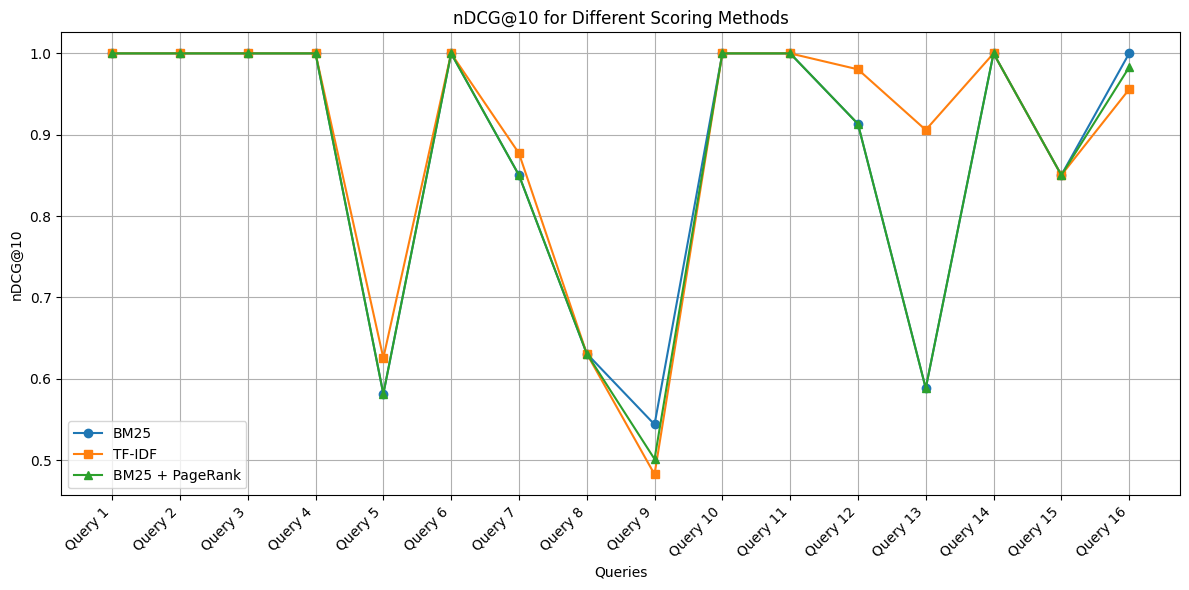

In [19]:
# Cell to generate line graphs for precision@k and nDCG@k with numbered query labels
import matplotlib.pyplot as plt

# Initialize lists to store metrics for each method
k = 10
bm25_precision = []
tfidf_precision = []
bm25_pr_precision = []
bm25_ndcg = []
tfidf_ndcg = []
bm25_pr_ndcg = []
queries = list(query_relevance_map.keys())

# Compute metrics for each query and scoring method
for query in queries:
    relevant = query_relevance_map[query]
    
    # BM25
    results_bm25 = search(query, inv_index, docs, meta, use_bm25=True, use_tfidf=False, expand=True, pagerank=None)
    bm25_precision.append(precision_at_k(results_bm25, relevant, k))
    bm25_ndcg.append(ndcg_at_k(results_bm25, relevant, k))
    
    # TF-IDF
    results_tfidf = search(query, inv_index, docs, meta, use_bm25=False, use_tfidf=True, expand=True, pagerank=None)
    tfidf_precision.append(precision_at_k(results_tfidf, relevant, k))
    tfidf_ndcg.append(ndcg_at_k(results_tfidf, relevant, k))
    
    # BM25 with PageRank
    results_bm25_pr = search(query, inv_index, docs, meta, use_bm25=True, use_tfidf=False, expand=True, pagerank=pagerank_scores)
    bm25_pr_precision.append(precision_at_k(results_bm25_pr, relevant, k))
    bm25_pr_ndcg.append(ndcg_at_k(results_bm25_pr, relevant, k))
    

# Create query labels as "Query 1", "Query 2", etc.
query_labels = [f"Query {i+1}" for i in range(len(queries))]

# Plot Precision@k
plt.figure(figsize=(12, 6))
plt.plot(range(len(queries)), bm25_precision, label='BM25', marker='o')
plt.plot(range(len(queries)), tfidf_precision, label='TF-IDF', marker='s')
plt.plot(range(len(queries)), bm25_pr_precision, label='BM25 + PageRank', marker='^')
plt.xlabel('Queries')
plt.ylabel(f'Precision@{k}')
plt.title(f'Precision@{k} for Different Scoring Methods')
plt.xticks(range(len(queries)), query_labels, rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot nDCG@k
plt.figure(figsize=(12, 6))
plt.plot(range(len(queries)), bm25_ndcg, label='BM25', marker='o')
plt.plot(range(len(queries)), tfidf_ndcg, label='TF-IDF', marker='s')
plt.plot(range(len(queries)), bm25_pr_ndcg, label='BM25 + PageRank', marker='^')

plt.xlabel('Queries')
plt.ylabel(f'nDCG@{k}')
plt.title(f'nDCG@{k} for Different Scoring Methods')
plt.xticks(range(len(queries)), query_labels, rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()